### OpenECCI Tutorials

Python Jupyter Notebooks for demonstrating a streamlined open-source workflow for Electron Channelling Contrast Imaging (ECCI) of crystal defects. For more technical details, please refer to [openECCI tutorial paper]()

Demo datasets: [Demo data link]()

#### Install prerequisite packages:

Create a new conda environment for openECCI<br>

`conda create --name openecci python=3.9`<br>
`conda activate openecci`

Install dependent Python packages:

PyQt `pip install pyqt5-tools`<br>
kikuchipy `pip install kikuchipy`<br>
orix `pip install orix`<br>
openCV `pip install opencv-python`<br>
tifffile `pip install tifffile`<br>
tqdm `pip install tqdm`<br>

### 01 Orientation calibration between EBSD map and ECP/ECCI imaging 
This notebook demonstrates the orientation calibration of the Reflected Kikuchi Patttern (RKP) simulation from corresponding EBSD results, such that the deviation between the reference frames can be minimized. In this process, a single crystal material (a Si wafer with [001] direction perpendicular to the surface was used in this demo) need to be attached together with the specimen of interest to assist the calibration. An automated matching routine is applied to mitigate the orientation deviation by quantitatively comparing the ECP (electron channelling pattern) of the Si [001] wafer and its simulated RKP pattern from EBSD Euler angles. 

#### Load dependent packages

In [1]:
import sys
sys.path.append("..")

import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import kikuchipy as kp
from openECCI import optimization, util, io, rkp

#### Load/locate the required data files
- Reference ECP from Si[001] wafer with no stage tilt or rotation
- Master pattern of Si simulated in EMsoft with the corresponding electron energy
- EBSD map file (.ctf is used) from the Si[001] wafer

In [2]:
# Path to Si ECP reference pattern
si_ref_ecp_path = Path("../data/fcc_fe/")
si_ref_ecp_file = "01_Si_ref.tif"
si_ref_ecp_fname = os.path.join(si_ref_ecp_path, si_ref_ecp_file)
ref_ecp = plt.imread(si_ref_ecp_fname)

# Path to Si master pattern @ 20kV generated by EMsoft
si_MP_path = Path("../data/ebsd_master_pattern/")
si_MP_file = "Si-master-20kv.h5"
si_MP_fname = os.path.join(si_MP_path, si_MP_file)
# si_MP = kp.load(si_MP_fname, projection="lambert", hemisphere="both", energy=20)
si_ECP_MP = kp.load(si_MP_fname, projection="lambert", hemisphere="both", energy=20)

# Path to Si .ctf file containing the EBSD euler angles
si_xmap_path = Path("../data/ebsd_map/")
si_xmap_file = "20kv_26nA_15mm WD_4x4 binning Si Map.ctf"
si_xmap_fname = os.path.join(si_xmap_path, si_xmap_file)

#### Manual adjustment of parameters to optimize the pattern fit

Reference frames in this calculation are defined as<br>

<img src="..\images\reference_frame.jpg" align="center" width="600"/>

Four optimization parameters are defined as:
- `tiltX_corr_angle` An "active" rotation about Xs axis (positive value => pattern moves LEFT).
- `tiltY_corr_angle` An "active" rotation about Ys axis (positive value => pattern moves DOWN).
- `tiltZ_corr_angle` An "active" rotation about Zs axis (positive value => pattern rotates COUNTER-CLOCKWISE).
- `PCz` is the third number of the RKP detector projection center triplet that controls the camera length (the definition follows Bruker EBSD projection center convention).

If the four parameters are all set to 0, there is an obvious deviation between the experimental ECP and the simulated RKP from EBSD average Eular angles. Manually adjust the four parameters so that the two patterns roughly matches.

(-0.5, 1023.5, 883.5, -0.5)

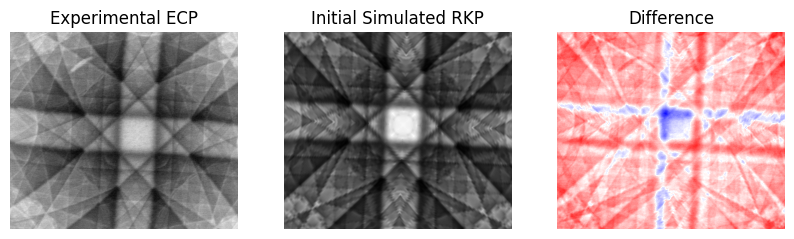

In [3]:
%matplotlib inline
# Get a approximate guess on the optimization parameters
tiltX_corr_angle = 0.1 # positive direction => pattern moves LEFT
tiltY_corr_angle = 0.5  # positive direction => pattern moves DOWN
tiltZ_corr_angle = 0 # positive direction => pattern rotates COUNTER-CLOCKWISE
PCz = 4 # Larger value => smaller angular range

# read the average orientation of Si EBSD map
si_average_rotation = io.get_avg_orientation(si_xmap_fname)
ecp_resolution = io.get_sem_metadata(si_ref_ecp_fname)["resolution"]

# simulate the ECP using the initial guess
sim_RKP_initial = rkp.get_sim_rkp(RKP_masterpattern = si_ECP_MP,
                              xtal_rotation = si_average_rotation,
                              st_rot_angle=0,
                              st_tilt_angle=0,
                              corr_angles=[tiltX_corr_angle, tiltY_corr_angle, tiltZ_corr_angle],
                              ref_ECP=si_ref_ecp_fname,
                              PCz=PCz,
                              RKP_shape=ecp_resolution)

fig1, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
ax1.imshow(ref_ecp[:ecp_resolution[1],:], cmap='gray')
ax1.set_title("Experimental ECP")
ax1.axis("off")

ax2.imshow(np.squeeze(sim_RKP_initial.data), cmap='gray')
ax2.set_title("Initial Simulated RKP")
ax2.axis("off")

ax3.imshow(util.normalize(ref_ecp[:ecp_resolution[1],:]) - util.normalize(np.squeeze(sim_RKP_initial.data)), cmap='bwr')
ax3.set_title("Difference")
ax3.axis("off")

#### Instantiate a new optimization_calibration object and initially set four parameters as input. 

Input parameters for the orientation_calibration object are:<br>
- Three rotational correction angles
- PCz or camera length
- Location of the reference ECP from Si[001] wafer
- Average orientation calculated from a small EBSD map of the Si wafer

Input parameters are summarized as output once the object is instantiated.

In [4]:
a = optimization.orientation_calibration(corr_angles=[tiltX_corr_angle, tiltY_corr_angle, tiltZ_corr_angle],
                            PCz=PCz,
                            reference_ECP_path=si_ref_ecp_fname,
                            si_master_pattern=si_ECP_MP,
                            Si_xtal=si_average_rotation)

Orientation Calibration Object created using the following parameters:               
Initial guess corrections: {'tiltX_corr_angle': 0.1, 'tiltY_corr_angle': 0.5, 'tiltZ_corr_angle': 0, 'PCz': 4},              
Reference ECP: ..\data\fcc_fe\01_Si_ref.tif,              
Master Pattern: <EBSDMasterPattern, title: , dimensions: (2|1001, 1001)>


#### Apply optimization to the orientation_calibration object
The orientation calibration (the four optimization parameters) is optimized by using the Nelder-Mead method in the Scipy package to find the best matching between experimental ECP and the simulated RKP. The pattern matching can be evaluated by using either the Normalized Dot product (NDP) or Modal Assurance Criterion (MAC) method. Optimization results will be summarized in the output cell.

In [5]:
optimized_results = a.optimize_calibration(method="MAC")

Optimization terminated successfully.
         Current function value: 0.069619
         Iterations: 188
         Function evaluations: 346
Rotation calibration optimized using MAC method
tiltX_corr_angle: -0.5311464280437883, tiltY_corr_angle: 1.2281663599252965, tiltZ_corr_angle: 0.06285233188175524 PCz: 3.890423190740525
MAC: 0.9303810883831488


#### Confirm the orientation calibration results

Plot the comparison of experimental ECP and simulated RKP after optimization to confirm. It is important that the location of projection center (red cross) in the experimental ECP should be consistent with that in simulated RKP after optimization.


Calibration of orientation correction coefficients:
{'tiltX_corr_angle': -0.5311464280437883, 'tiltY_corr_angle': 1.2281663599252965, 'tiltZ_corr_angle': 0.06285233188175524, 'PCz': 3.890423190740525}


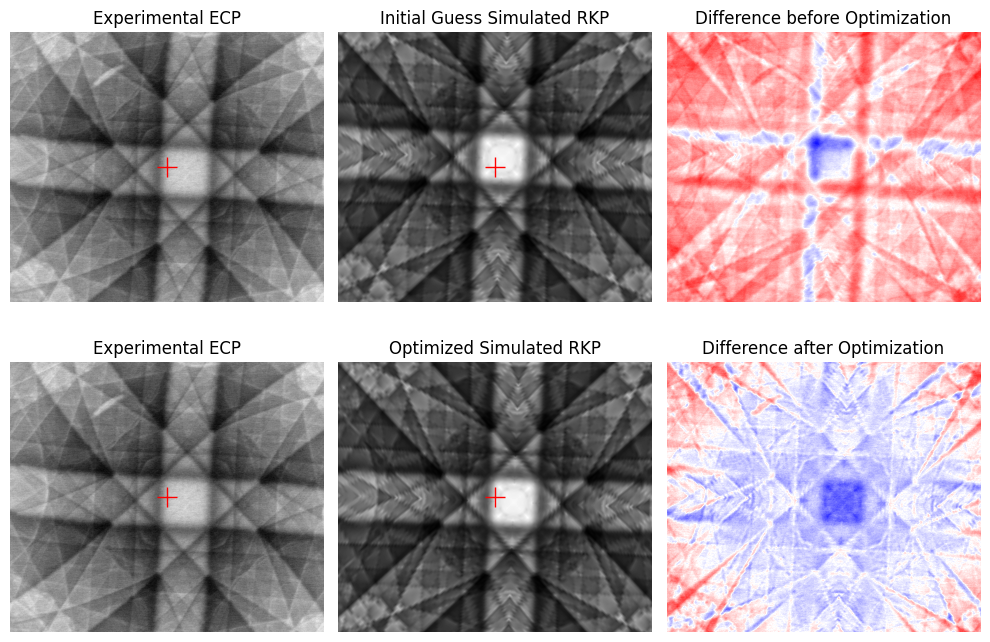

In [6]:
%matplotlib inline

tiltX_corr_angle_op = optimized_results["tiltX_corr_angle"] # positive direction => pattern moves DOWN
tiltY_corr_angle_op = optimized_results["tiltY_corr_angle"] # positive direction => pattern moves LEFT
tiltZ_corr_angle_op = optimized_results["tiltZ_corr_angle"] # positive direction => pattern rotates COUNTER-CLOCKWISE
PCz_op = optimized_results["PCz"] # Larger value => smaller angular range

# simulate the ECP using the initial guess
sim_RKP_optimized = rkp.get_sim_rkp(RKP_masterpattern = si_ECP_MP,
                              xtal_rotation = si_average_rotation,
                              st_rot_angle=0,
                              st_tilt_angle=0,
                              corr_angles=[tiltX_corr_angle_op, tiltY_corr_angle_op, tiltZ_corr_angle_op],
                              ref_ECP=si_ref_ecp_fname,
                              PCz=PCz_op,
                              RKP_shape=ecp_resolution)

fig1, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,7))

axs[0,0].imshow(ref_ecp[:ecp_resolution[1],:], cmap='gray')
axs[0,0].plot(ecp_resolution[0]//2, ecp_resolution[1]//2, 'r+', markersize=14)
axs[0,0].set_title("Experimental ECP")
axs[0,0].axis("off")

axs[0,1].imshow(np.squeeze(sim_RKP_initial.data), cmap='gray')
axs[0,1].plot(ecp_resolution[0]//2, ecp_resolution[1]//2, 'r+', markersize=14)
axs[0,1].set_title("Initial Guess Simulated RKP")
axs[0,1].axis("off")

axs[0,2].imshow(util.normalize(ref_ecp[:ecp_resolution[1],:]) - util.normalize(np.squeeze(sim_RKP_initial.data)), cmap='bwr')
axs[0,2].set_title("Difference before Optimization")
axs[0,2].axis("off")

axs[1,0].imshow(ref_ecp[:ecp_resolution[1],:], cmap='gray')
axs[1,0].plot(ecp_resolution[0]//2, ecp_resolution[1]//2, 'r+', markersize=14)
axs[1,0].set_title("Experimental ECP")
axs[1,0].axis("off")

axs[1,1].imshow(np.squeeze(sim_RKP_optimized.data), cmap='gray')
axs[1,1].plot(ecp_resolution[0]//2, ecp_resolution[1]//2, 'r+', markersize=14)
axs[1,1].set_title("Optimized Simulated RKP")
axs[1,1].axis("off")

axs[1,2].imshow(util.normalize(ref_ecp[:ecp_resolution[1],:]) - util.normalize(np.squeeze(sim_RKP_optimized.data)), cmap='bwr')
axs[1,2].set_title("Difference after Optimization")
axs[1,2].axis("off")

plt.tight_layout()

print(f"Calibration of orientation correction coefficients:\n{optimized_results}")

# plt.savefig("optimization_results.png", dpi=600, bbox_inches="tight")